# Comparison between kernel-based training and variational circuit using Covalent and Pennylane


In this tutorial, we show how kernel-based training compares with variational training in terms of the number of quantum circuits that have to be evaluated. This becomes important as each circuit evaluation on a real quantum hardware is expensive and time consuming. We also discuss how Covalent can help in situations where multiple evaluations of quantum circuits are needed.



In [2]:
import numpy as np
import torch
from torch.nn.functional import relu

from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pennylane as qml
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from pennylane.operation import Tensor

import matplotlib.pyplot as plt

import covalent as ct


from covalent.executor import DaskExecutor
from dask.distributed import LocalCluster

from dask.distributed import LocalCluster
cluster=LocalCluster()
dask=ct.executor.DaskExecutor(scheduler_address=cluster.scheduler_address) 

np.random.seed(42)

distributed.diskutils - INFO - Found stale lock file and directory '/home/poojith/agnostiq/dask-worker-space/worker-n_r2nqtn', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/poojith/agnostiq/dask-worker-space/worker-flkr06ce', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/poojith/agnostiq/dask-worker-space/worker-qel2w5xg', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/poojith/agnostiq/dask-worker-space/worker-7rlo7e61', purging


# Load, preprocess and split data

We use the Iris dataset in this tutorial. We do some necessary preprocessing on the data and split them into training and test dataset.

### Iris dataset

Iris dataset is a very well known dataset used for pattern recognition and classification. It consists of 50 samples belonging to 3 classes namely: Iris Setosa, Iris Versicolour and Iris Virginica. Each sample has four features related to the length and width of sepal and petal.

For the sake of simplicity of the model, we compress the number of features dataset into 2 using PCA. We will be using a pre-trained model and the PyTorch interface and we’ll see that ensembling allows each set of parameters to specialize towards different classes.

In [3]:
X, y = load_iris(return_X_y=True)

# pick inputs and labels from the first two classes only,
# corresponding to the first 100 samples
X = X[:100]
y = y[:100]

# scaling the inputs is important since the embedding we use is periodic
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# scaling the labels to -1, 1 is important for the SVM and the
# definition of a hinge loss
y_scaled = 2 * (y - 0.5)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled)

# Constructing the workflow for kernel-based training

The workflow for training based on kernel is broken down into subtasks (functions with the Covalent electron decorator) as follows.

1. `kernel` - The quantum kernel evaluator which calculates the kernel function value between two values.
2. `kernel_matrix` - Compute the matrix whose entries are the kernel evaluated on pairwise data from sets A and B.
3. `fit_SVC` - It fits a Support Vector Classifer for the supplied kernel matrix.
4. `predict_SVC` - It predicts the classes using the trained SVC.
5. `get_accuracy_score` - Returns the accuracy score for the predicted classes.


In [4]:
n_qubits = len(X_train[0])

dev_kernel = qml.device("default.qubit", wires=n_qubits)

projector = np.zeros((2**n_qubits, 2**n_qubits))
projector[0, 0] = 1

@ct.electron()
@qml.qnode(dev_kernel)
def kernel(x1, x2):
    """The quantum kernel."""
    AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

In [5]:
@ct.electron()
def kernel_matrix(A, B):
    """Compute the matrix whose entries are the kernel
       evaluated on pairwise data from sets A and B."""
    return np.array([[kernel(a, b) for b in B] for a in A])

@ct.electron()
def fit_SVC(X_train, y_train,kernel_matrix):
    svm = SVC(kernel=kernel_matrix).fit(X_train, y_train)
    return svm

@ct.electron()
def predict_SVC(svm, X_test):
    predictions = svm.predict(X_test)
    return predictions

@ct.electron()
def get_accuracy_score(predictions, y_test):
    return accuracy_score(predictions, y_test)


In [6]:
@ct.lattice(executor=dask)
def kernel_workflow(X_train, y_train, X_test, y_test, kernel_matrix):
    svm = fit_SVC(X_train, y_train, kernel_matrix)
    predictions = predict_SVC(svm,X_test)
    acc = get_accuracy_score(predictions, y_test)
    return acc

In [7]:
dispatch_id = ct.dispatch(kernel_workflow)(X_train, y_train, X_test, y_test, kernel_matrix)

In [8]:
kernel_result = ct.get_result(dispatch_id=dispatch_id, wait=True)
kernel_result.result

1.0

In [9]:
dev_kernel.num_executions

0

# Constructing the workflow for variational training

The workflow for training based on variational circuit is broken down into subtasks (functions with the Covalent electron decorator) as follows.

1. `quantum_model` - Evaluates the quantum variational circuit.
2. `quantum_model_plus_bias` - Adds bias to the output of the circuit.
3. `hinge_loss` - Calculates the hinge loss between the predictions and target value.
4. `get_params` - Returns random initial parameters as torch objects.
5. `get_optimizer` - Returns the the optimizer needed for training.
6. `get_batch_data` - Returns the samples used for training in a particular batch.
7. `step_optimizer` - Performs one step of optimization during training.
8. `get_random` - Returns random indexes needed to choose batch.
9. `get_torch` - Converts an array into a torch object.
10. `get_pred` - Predict the class based on the output of the model.

In [10]:
dev_var = qml.device("default.qubit", wires=n_qubits)

@ct.electron()
@qml.qnode(dev_var, interface="torch", diff_method="parameter-shift")
def quantum_model(x, params):
    """A variational quantum model."""

    # embedding
    AngleEmbedding(x, wires=range(n_qubits))

    # trainable measurement
    StronglyEntanglingLayers(params, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

@ct.electron()
def quantum_model_plus_bias(x, params, bias):
    """Adding a bias."""
    return quantum_model(x, params) + bias

@ct.electron()
def hinge_loss(predictions, targets):
    """Implements the hinge loss."""
    all_ones = torch.ones_like(targets)
    hinge_loss = all_ones - predictions * targets
    # trick: since the max(0,x) function is not differentiable,
    # use the mathematically equivalent relu instead
    hinge_loss = relu(hinge_loss)
    return hinge_loss

In [11]:
@ct.electron()
def get_params(n_layers):
    params = np.random.random((n_layers, n_qubits, 3))
    params_torch = torch.tensor(params, requires_grad=True)
    bias_torch = torch.tensor(0.0)
    return params_torch, bias_torch

@ct.electron()
def get_optimizer(params_torch, bias_torch):
    return torch.optim.Adam([params_torch, bias_torch], lr=0.1)

@ct.electron()
def get_batch_data(batch_ids):
    X_batch = X_train[batch_ids]
    y_batch = y_train[batch_ids]

    X_batch_torch = torch.tensor(X_batch, requires_grad=False)
    y_batch_torch = torch.tensor(y_batch, requires_grad=False)
    
    return X_batch_torch, y_batch_torch


@ct.electron()
def step_optimizer(opt, params_torch, bias_torch,  X_batch_torch, y_batch_torch):
    def closure():
        opt.zero_grad()
        preds = torch.stack(
            [quantum_model_plus_bias(x, params_torch, bias_torch) for x in X_batch_torch]
        )
        loss = torch.mean(hinge_loss(preds, y_batch_torch))

        # bookkeeping
        current_loss = loss.detach().numpy().item()

        loss.backward()
        return loss

    opt.step(closure)
    current_loss = closure().detach().numpy().item()
    return opt, current_loss

@ct.electron()
def get_random(n, batch_size):
    return np.random.choice(n, batch_size)



In [13]:
@ct.lattice()
def quantum_model_train(n_layers, steps, batch_size):
    """Train the quantum model defined above."""
    
    params_torch, bias_torch = get_params(n_layers)

    opt = get_optimizer(params_torch, bias_torch)

    loss_history = []
    
    for i in range(steps):

        batch_ids = get_random(len(X_train), batch_size)

        X_batch_torch, y_batch_torch = get_batch_data(batch_ids=batch_ids)

        opt = get_optimizer(params_torch=params_torch, bias_torch=bias_torch)       
        
        opt, current_loss = step_optimizer(opt = opt,params_torch = params_torch, bias_torch = bias_torch,  X_batch_torch = X_batch_torch, y_batch_torch = y_batch_torch)
        
        loss_history.append(current_loss)
        
    return params_torch, bias_torch, loss_history


@ct.electron()
def get_torch(x):
    return torch.tensor(x)

@ct.electron()
def get_pred(pred_torch):
    pred = pred_torch.detach().numpy().item()
    if pred > 0:
        pred = 1
    else:
        pred = -1        
    return pred

@ct.lattice(executor=dask)
def quantum_model_predict(X_pred, trained_params, trained_bias):
    """Predict using the quantum model defined above."""

    p = []
    for x in X_pred:

        x_torch = get_torch(x=x)
        pred_torch = quantum_model_plus_bias(x=x_torch, params=trained_params, bias=trained_bias)
        
        pred = get_pred(pred_torch=pred_torch)
        p.append(pred)
    return p

### Training workflow

We use the `quantum_model_train` function with Covalent lattice decorator for creating the workflow for training the variational circuit.

The workflow runs each step of optimization inside the lattice and hence it can save the intermediate optimization steps. This has an advantage when the code is run on an actual quantum hardware as usually each step would be both time and resource costly and hence we would want to monitor not only at the main optimization level, but also at iteration level.

From the DAGs we can see how the results are saved as each step and if any step fails we can use the saved previous computed results to continue further.

We similarly use the `quantum_model_predict` for predicting the classes of different samples. The output is used to compute the accuracy. The output of the workflow is used to plot the loss function.

accuracy on test set: 0.96


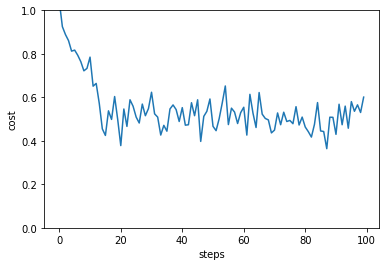

In [16]:
n_layers = 2
batch_size = 20
steps = 100


dispatch_id_train = ct.dispatch(quantum_model_train)(n_layers, steps, batch_size)
train_result = ct.get_result(dispatch_id=dispatch_id_train, wait=True)
trained_params, trained_bias, loss_history = train_result.result


dispatch_id_predict = ct.dispatch(quantum_model_predict)(X_test, trained_params, trained_bias)
pred_result = ct.get_result(dispatch_id=dispatch_id_pred, wait=True)
pred_test = pred_result.result

print("accuracy on test set:", accuracy_score(pred_test, y_test))

plt.plot(loss_history)
plt.ylim((0, 1))
plt.xlabel("steps")
plt.ylabel("cost")
plt.show()

In [17]:
def circuit_evals_kernel(n_data, split):
    """Compute how many circuit evaluations one needs for kernel-based
       training and prediction."""

    M = int(np.ceil(split * n_data))
    Mpred = n_data - M

    n_training = M * M
    n_prediction = M * Mpred

    return n_training + n_prediction

circuit_evals_kernel(n_data=len(X), split=len(X_train) /(len(X_train) + len(X_test)))

7500

In [18]:
def circuit_evals_variational(n_data, n_params, n_steps, shift_terms, split, batch_size):
    """Compute how many circuit evaluations are needed for
       variational training and prediction."""

    M = int(np.ceil(split * n_data))
    Mpred = n_data - M

    n_training = n_params * n_steps * batch_size * shift_terms
    n_prediction = Mpred

    return n_training + n_prediction

circuit_evals_variational(
    n_data=len(X),
    n_params=len(trained_params.flatten()),
    n_steps=steps,
    shift_terms=2,
    split=len(X_train) /(len(X_train) + len(X_test)),
    batch_size=batch_size,
)

96025

In [19]:
def model_evals_nn(n_data, n_params, n_steps, split, batch_size):
    """Compute how many model evaluations are needed for neural
       network training and prediction."""

    M = int(np.ceil(split * n_data))
    Mpred = n_data - M

    n_training = n_steps * batch_size
    n_prediction = Mpred

    return n_training + n_prediction

model_evals_nn(
    n_data=len(X),
    n_params=len(trained_params.flatten()),
    n_steps=steps,
    split=len(X_train) /(len(X_train) + len(X_test)),
    batch_size=batch_size,
)

2025

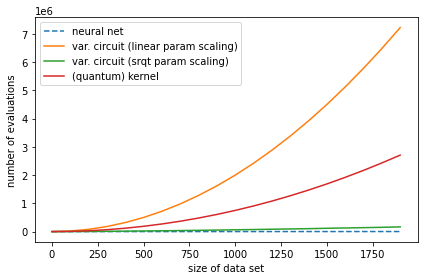

In [20]:
variational_training1 = []
variational_training2 = []
kernelbased_training = []
nn_training = []
x_axis = range(0, 2000, 100)

for M in x_axis:

    var1 = circuit_evals_variational(
        n_data=M, n_params=M, n_steps=M,  shift_terms=2, split=0.75, batch_size=1
    )
    variational_training1.append(var1)

    var2 = circuit_evals_variational(
        n_data=M, n_params=round(np.sqrt(M)), n_steps=M,
        shift_terms=2, split=0.75, batch_size=1
    )
    variational_training2.append(var2)

    kernel = circuit_evals_kernel(n_data=M, split=0.75)
    kernelbased_training.append(kernel)

    nn = model_evals_nn(
        n_data=M, n_params=M, n_steps=M, split=0.75, batch_size=1
    )
    nn_training.append(nn)


plt.plot(x_axis, nn_training, linestyle='--', label="neural net")
plt.plot(x_axis, variational_training1, label="var. circuit (linear param scaling)")
plt.plot(x_axis, variational_training2, label="var. circuit (srqt param scaling)")
plt.plot(x_axis, kernelbased_training, label="(quantum) kernel")
plt.xlabel("size of data set")
plt.ylabel("number of evaluations")
plt.legend()
plt.tight_layout()
plt.show()